In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


from os import listdir
from os.path import isfile, join
import import_ipynb
from Utilities import *

ModuleNotFoundError: No module named 'Utilities'

Calculate from two subsequent images the transition matrix/matrices.

In [15]:
path = './output/'
files = [f for f in listdir(path) if isfile(join(path, f))]

image1 = xr.open_dataset(path + files[0])
image2 = xr.open_dataset(path + files[1])


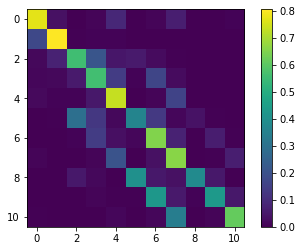

to,0,1,2,3,4,5,6,7,8,9,10
from,,,,,,,,,,,
0,106145,4969,90,1683,12517,12,1477,9225,1,202,878
1,4709,21744,141,180,191,3,12,2,0,0,0
2,42,197,1431,540,125,145,63,10,1,1,0
3,111,129,424,4139,1047,64,1246,176,0,12,1
4,466,184,183,1203,16632,8,272,3639,0,2,61
5,1,3,184,82,10,229,84,8,24,2,1
6,19,5,59,1110,262,99,5117,606,7,500,45
7,213,6,17,209,3845,4,686,12455,0,69,1287
8,0,0,3,1,0,23,3,2,22,3,0


In [3]:
def countTransitions(image1, image2):
    # check
    if np.abs(image1.time - image2.time) > np.timedelta64(15, 'm'):
        print(f'{image1.time} and {image2.time} images are not subsequent')

    M = pd.crosstab(image1.ct.data.flatten(), image2.ct.data.flatten(),
                    rownames = ['from'],
                    colnames = ['to'],
    #                 normalize = 'index'
                   )
    return M

M = countTransitions(image1, image2)

def plotMnorm(M):
    M_norm = M.div(M.sum(axis=1), axis=0)
    plt.imshow(M_norm)
    plt.colorbar()
    
plotMnorm(M)
plt.show()
M


In [4]:
### evolution of one pixel
files = [f for f in listdir(path) if f[6:14] in ['20200101']]

ds = xr.open_dataset(path + files[0])

M =  pd.DataFrame(0, index=np.arange(11), columns=np.arange(11))
for f in files[1:]:
    image = xr.open_dataset(path + f)
    ds = xr.concat([ds, image], dim = 'time')
    trans = countTransitions(ds.isel(time = -2), ds.isel(time = -1)).fillna(0)
    M.loc[trans.index, trans.columns] = M.loc[trans.index, trans.columns] + trans


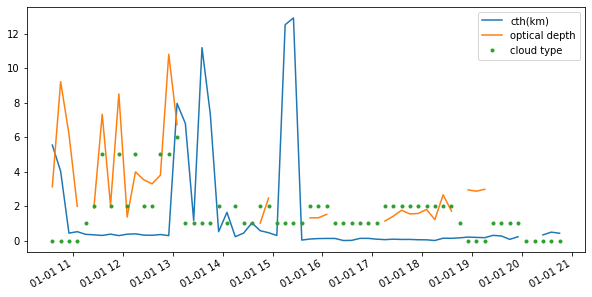

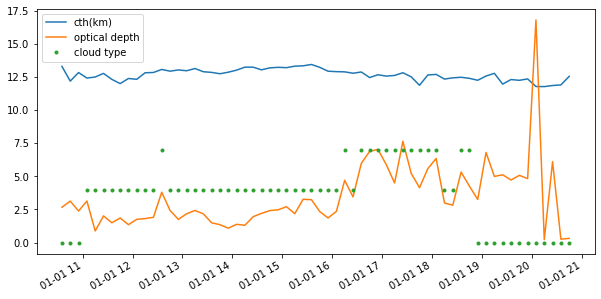

In [5]:
i,j = 100, 200 # index of pixel p
p =  ds.isel(x = i, y = j)
def plotOnePixelTS(p):
    plt.figure(figsize = (10, 5))
    plt.plot(p.time, p.cth*1e-3, label ='cth(km)')
    plt.plot(p.time, p.cod, label = 'optical depth')
    plt.plot(p.time, p.ct, '.', label = 'cloud type')
#     plt.plot(p.time, p.dqf_cod, '.', label = 'DQF')
    plt.gcf().autofmt_xdate()
    plt.legend()

plotOnePixelTS(p)
plt.show()

i,j = 200, 180 # index of pixel p
p =  ds.isel(x = i, y = j)
plotOnePixelTS(p)
plt.show()

In [6]:
ds

<xarray.Dataset>
Dimensions:  (time: 62, x: 535, y: 430)
Coordinates:
  * x        (x) float64 0.0 0.001873 0.003745 0.005618 ... 0.9963 0.9981 1.0
  * y        (y) float64 0.0 0.002331 0.004662 0.006993 ... 0.9953 0.9977 1.0
  * time     (time) datetime64[ns] 2020-01-01T10:35:07.201287936 ... 2020-01-...
Data variables:
    cod      (time, x, y) float32 33.97 34.25 12.33 ... nan 0.04151 0.03418
    dqf_cod  (time, x, y) float32 4.0 4.0 4.0 4.0 4.0 ... 1.0 1.0 7.0 1.0 1.0
    cth      (time, x, y) float32 2.187e+03 2.187e+03 ... 1.277e+04 1.277e+04
    ct       (time, x, y) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    extent:   [-50. -30.  -5.  15.]

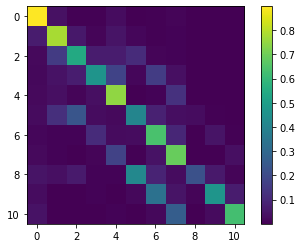

,0,1,2,3,4,5,6,7,8,9,10,total
0,2366121,108638,11508,11472,74965,5337,13499,32810,330,2545,5688,2722886
1,153529,1741126,130920,30801,102789,35385,10775,19188,583,482,182,2201656
2,18214,116906,410922,52421,51137,83297,9738,7415,1878,256,155,749784
3,14802,32410,52093,334659,130735,10349,114418,27128,298,1850,386,711779
4,71896,126647,46835,126817,2548176,6795,29114,439522,165,363,3223,3376903
5,9269,40149,78830,9903,7248,135922,27005,10890,9731,2174,601,331094
6,16511,9771,10699,117532,28878,30696,674587,102434,2599,49740,7342,1042960
7,52391,24335,6160,26647,429968,10017,106613,1671130,549,7187,89086,2405292
8,1153,842,1494,207,170,9920,2093,691,5284,1416,287,23500
9,4387,497,196,1050,299,2783,48240,7047,1820,67086,9915,142034


In [7]:
plotMnorm(M)
plt.show()
M['total'] = np.sum(M)
M

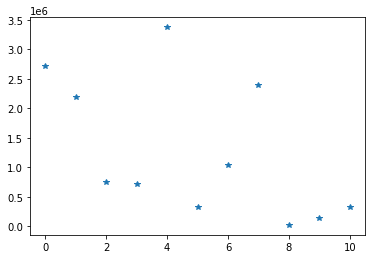

In [8]:
plt.plot(M.total, '*')

## Spatial Correlations

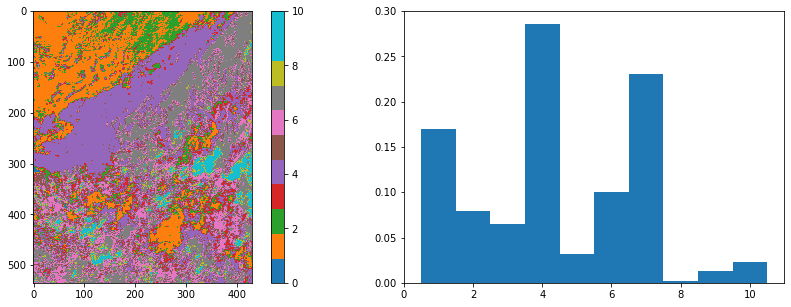

In [288]:
from pylab import *


image = ds.isel(time = 30)
fig, ax = plt.subplots(1,2,figsize = (15, 5))
cmap = cm.get_cmap('tab10', 11) 
figim = ax[0].imshow(image.ct, cmap = cmap)
fig.colorbar(figim, ax =ax[0])

histClassifications(image.ct.data, ax[1])
# ax[1].hist(image.ct.data.flatten())
plt.show()


In [281]:
def directions(di, dj):
    drcts = [[di, dj], 
            [di, -dj],
            [-di, dj],
             [-di, -dj],
            ]
    return drcts

def allDirections(di, dj):
    drcts = np.array(directions(di, dj)+ directions(dj, di))
    return np.unique(drcts, axis = 0)

spatial = xr.Dataset(
         {
        "transition_count": (["f", "to"], np.eye(11)),
    },
    coords={
         "f": (["f"], np.arange(11)),
         "to": (["to"], np.arange(11)),
        "d": ([0]),
    },
 )

ds = xr.concat([ds, image], dim = 'time')

L = 50

for di in range(1,L): # order neighbour
    for dj in range(di):  ## ordering can be done differently
        center = image.ct[di:-di, di:-di]
        s_center = center.shape
        directs = allDirections(di,dj)
        A = np.zeros((11,11))
        for i, j in directs:
            left, top = di + i, di + j,
            shift = image.ct[left:left + s_center[0], top:top + s_center[1]] ## shifted image
            M = pd.crosstab(center.data.flatten(), shift.data.flatten())
            M = M.to_numpy()
            A += M
        A = normalize(A, axis=1, norm='l1')
        d = np.sqrt(di ** 2 + dj ** 2)
        order = xr.Dataset(
                         {
                        "transition_count": (["f", "to"], A),
                    },
                    coords={
                         "f": (["f"], np.arange(11)),
                         "to": (["to"], np.arange(11)),
                        "d": (d),
                    },
                 )
        spatial = xr.concat([spatial, order], dim = 'd')

spatial = spatial.sortby('d')

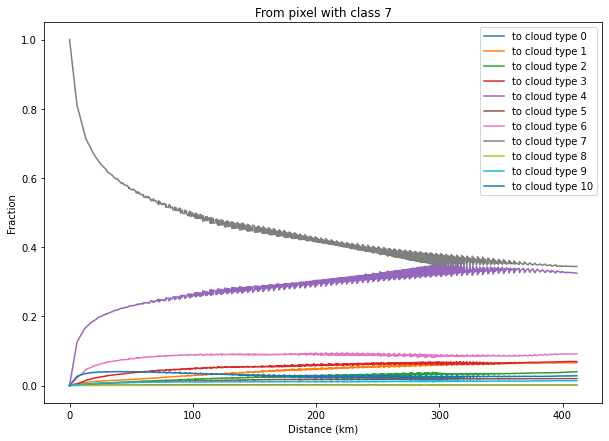

In [287]:
i = 7

plt.figure(figsize = (10,7))
for j in range(11):
    plt.plot(spatial.d * 6, spatial.isel(f = i, to = j).transition_count, label = f'to cloud type {j}')
plt.title(f'From pixel with class {i}')
plt.xlabel('Distance (km)')
plt.ylabel('Fraction')
plt.legend()
# spatial.d

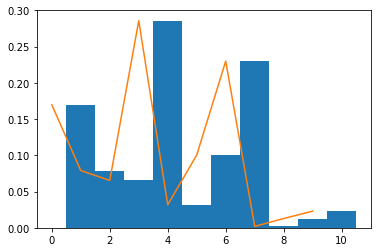

In [279]:
apriori , bins, hist = histClassifications(image.ct.data, ax[1])


In [17]:
image1

<xarray.Dataset>
Dimensions:  (x: 535, y: 430)
Coordinates:
  * x        (x) float64 0.0 0.001873 0.003745 0.005618 ... 0.9963 0.9981 1.0
  * y        (y) float64 0.0 0.002331 0.004662 0.006993 ... 0.9953 0.9977 1.0
    time     datetime64[ns] 2000-01-01T11:43:21
Data variables:
    cod      (x, y) float32 ...
    dqf_cod  (x, y) float32 ...
    cth      (x, y) float32 ...
    ct       (x, y) int32 ...
Attributes:
    extent:   [-50. -30.  -5.  15.]

In [44]:
df = pd.DataFrame(columns = ['COD', 'CTH', 'ct'])
for i in range(5):
    df_add = pd.DataFrame(np.array([image1.cod.data.flatten(), image1.cth.data.flatten(), image1.ct.data.flatten()]).T, columns = ['COD', 'CTH', 'ct'])
    df = df.append(df_add.loc[df_add.ct != 0], ignore_index=True)

# library & dataset
# import seaborn as sns
# import matplotlib.pyplot as plt
# # df = sns.load_dataset('iris')

# # df = pd.DataSet
 
# # # Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
# sns.jointplot(x=df["COD"], y=df["CTH"], kind='kde')
# sns
# # Custom the color, add shade and bandwidth
# # sns.kdeplot(df, cmap="Reds", shade=True, bw_adjust=.5)
# plt.show()
df


,COD,CTH,ct
0,NaN,278.650970,1.0
1,NaN,278.650970,1.0
2,3.164352,NaN,4.0
3,2.746834,NaN,4.0
4,2.422097,NaN,4.0
...,...,...,...
230045,1.567526,11993.895508,4.0
230046,0.659240,13030.061523,4.0
230047,0.800855,13030.061523,4.0
230048,0.659240,12968.411133,4.0


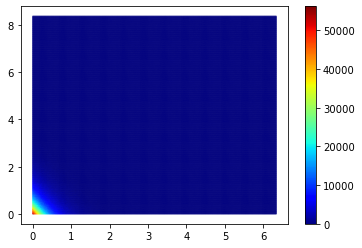

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x, y = -np.log10(np.random.random_sample((2,10**6)))

#histogram definition
bins = [500, 500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)
xv, yv = np.meshgrid(locx[:-1], locy[:-1])

for i in range(50):
    hh2, locx, locy = np.histogram2d(x, y, bins=bins)
    hh = hh + hh2
# Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
# idx = z.argsort()
# x2, y2, z2 = x[idx], y[idx], z[idx]

# plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(xv, yv, c=hh, cmap='jet', marker='.', s = .1)  
plt.colorbar()

In [7]:
hh.shape

(1000, 1000)